In [18]:
#THIS FILE IS USED TO TEST IF STU => LDS vs just LDS is better at learning things (such as a noised LDS)

import torch
import torch.nn as nn
import torch.nn.functional  as  F
import math
import numpy as np

device = torch.device("cuda"  if torch.cuda.is_available() else "cpu")

In [19]:
import torch
import torch.nn.functional as F
import math

def nearest_power_of_two(x: int, round_up: bool = False) -> int:
    return (
        1 << math.floor(math.log2(x)) if not round_up else 1 << math.ceil(math.log2(x))
    )

def convolve(u: torch.Tensor, v: torch.Tensor, n: int, use_approx: bool = True) -> tuple[torch.Tensor, torch.Tensor]:
    # print(u.shape, v.shape)
    bsz, seq_len, d_in = u.shape

    sgn = torch.full((1, seq_len, 1), 1, device=u.device)
    sgn[:, 1::2] *= -1

    _, K = v.shape
    sgn = sgn.unsqueeze(-1)
    v = v.view(1, -1, K, 1, 1).to(torch.float32) # (bsz, seq_len, K, d_in, stack)
    u = u.view(bsz, -1, 1, d_in).expand(bsz, -1, K, d_in)

    v = torch.fft.rfft(v, n=n, dim=1)
    U = torch.stack([u, u * sgn], dim=-1).to(torch.float32)
    U = torch.fft.rfft(U, n=n, dim=1)
    U_conv = torch.fft.irfft(v * U, n=n, dim=1)[:, :seq_len]
    U_plus, U_minus = torch.unbind(U_conv, dim=-1)
    U_minus = U_minus * sgn

    return U_plus, U_minus

In [20]:
def get_hankel(seq_len: int, use_hankel_L: bool = False) -> np.ndarray:
    entries = np.arange(1, seq_len + 1, dtype=np.float64)
    i_plus_j = entries[:, None] + entries[None, :]

    if use_hankel_L:
        sgn = (-1.0) ** (i_plus_j - 2.0) + 1.0
        denom = (i_plus_j + 3.0) * (i_plus_j - 1.0) * (i_plus_j + 1.0)
        Z = sgn * (8.0 / denom)
    elif not use_hankel_L:
        Z = 2.0 / (i_plus_j**3 - i_plus_j)
    else:
        raise ValueError("use_hankel_L must be a boolean")

    return Z

def get_spectral_filters(
    seq_len: int,
    K: int,
    use_hankel_L: bool = False,
    device: torch.device = None,
    dtype: torch.dtype = torch.bfloat16,
) -> torch.Tensor:
    assert torch.cuda.is_available(), "CUDA is required."
    Z = get_hankel(seq_len, use_hankel_L)
    sigma, phi = np.linalg.eigh(Z)
    sigma_k, phi_k = sigma[-K:], phi[:, -K:]
    phi_k *= sigma_k ** 0.25
    filters = torch.from_numpy(phi_k)
    return filters.to(device=device, dtype=dtype)


In [21]:
class STU(nn.Module):
    def __init__(self, config, phi) -> None:
        super(STU, self).__init__()
        self.config = config
        self.phi = phi
        self.n = nearest_power_of_two(config['seq_len'] * 2 - 1, round_up=True)
        self.K = config['num_eigh']
        self.d_in = config['d_in']
        self.d_out = config['d_out']
        self.use_hankel_L = config['use_hankel_L']
        self.use_approx = False
        self.M_phi_plus = nn.Parameter(
            torch.randn(self.K, self.d_in, self.d_out, dtype=config['torch_dtype']) / 10
        )

        self.M_phi_minus = nn.Parameter(
            torch.randn(self.K, self.d_in, self.d_out, dtype=config['torch_dtype']) / 10
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:

        # Convolve inputs and filters,
        U_plus, U_minus = convolve(x, self.phi, self.n, False)
        # Then, contract over the K and d_in dimensions

        # print(U_plus.shape, U_minus.shape)
        spectral_plus = torch.tensordot(
            U_plus, self.M_phi_plus, dims=([2, 3], [0, 1])
        )

        spectral_minus = torch.tensordot(
            U_minus, self.M_phi_minus, dims=([2, 3], [0, 1])
        )

        # print(spectral_plus.shape)

        return spectral_plus if self.use_hankel_L else spectral_plus + spectral_minus

    def loss(self, inputs, targets):
        pred = self.forward(inputs)
        # print(pred, targets)
        loss = F.mse_loss(pred, targets)
        return  loss



In [31]:
import copy
import torch

class General_LDS:
    def __init__(self,A: torch.Tensor,B: torch.Tensor,C: torch.Tensor,D: torch.Tensor,h0: torch.Tensor,input_noise_variance: float=0.0,output_noise_variance: float=0.0):
        self.d_h = A.shape
        _, self.d_u = B.shape
        self.d_o,_ = C.shape
        self.A = A
        self.B = B
        self.C = C
        self.D = D
        self.h0 = h0
        self.h = h0
        self.input_noise_variance = input_noise_variance
        self.output_noise_variance = output_noise_variance
    def step(self,u: torch.Tensor)->torch.Tensor:
        if self.input_noise_variance>0.0:
            noise_in = torch.randn_like(u)*(self.input_noise_variance**0.5)
            u_noisy = u+noise_in
        else:
            u_noisy = u
        h_next = self.A@self.h+self.B@u_noisy
        obs = self.C@h_next+self.D@u_noisy
        if self.output_noise_variance>0.0:
            noise_out = torch.randn_like(obs)*(self.output_noise_variance**0.5)
            obs_noisy = obs+noise_out
        else:
            obs_noisy = obs
        self.h = h_next
        return obs_noisy
    def reset(self):
        self.h = self.h0
        return self
    def generate_trajectory(self,us: torch.Tensor,h0: torch.Tensor=None,return_hidden_state: bool=False)->torch.Tensor:
        if h0 is not None:
            self.h = h0
        _,d_u = us.shape
        assert d_u==self.d_u,(d_u,self.d_u)
        obs = []
        hds = []
        h0_copy = copy.copy(self.h0)
        for u in us:
            obs_step = self.step(u)
            obs.append(obs_step)
            if return_hidden_state:
                hds.append(copy.copy(self.h))
        if return_hidden_state:
            return torch.stack(obs,dim=0),torch.stack(hds,dim=0),h0_copy
        return torch.stack(obs,dim=0)

def random_general_LDS(d_h: int,d_o: int,d_u: int,delta: float,input_noise_variance: float=0.0,output_noise_variance: float=0.0):
    A = torch.rand(d_h,d_h)
    spectral_norm = torch.linalg.norm(A,ord=2)
    A = (1-delta)*(A/spectral_norm)
    B = torch.rand(d_h,d_u)/d_u
    C = torch.rand(d_o,d_h)/d_h
    D = torch.zeros(d_o,d_u)
    h0 = torch.zeros(d_h)
    return General_LDS(A,B,C,D,h0,input_noise_variance,output_noise_variance)


In [32]:
class LDSModel(nn.Module):
    def __init__(self, state_dim, input_dim, output_dim, kx=5):
        super(LDSModel, self).__init__()
        self.state_dim = state_dim
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.kx = kx
        self.h0 = nn.Parameter(torch.randn(state_dim))
        init_A = torch.randn(state_dim)
        self.A = nn.Parameter(init_A / torch.max(torch.abs(init_A)))
        self.B = nn.Parameter(torch.randn(input_dim, state_dim) / input_dim)
        self.C = nn.Parameter(torch.randn(state_dim, output_dim) / state_dim)
        # self.M = nn.Parameter(torch.randn(input_dim, output_dim, kx) / (output_dim))

    def forward(self, inputs):
        device = inputs.device
        bsz, seq_len, _ = inputs.shape
        h_t = self.h0.expand(bsz, self.state_dim).to(device)
        A = self.A.flatten()
        all_h_t = []
        for t in range(seq_len):
            u_t = inputs[:, t, :]
            h_t = A * h_t + (u_t @ self.B)
            all_h_t.append(h_t.unsqueeze(1))
        all_h_t = torch.cat(all_h_t, dim=1)
        lds_out = torch.matmul(all_h_t, self.C)

        # ar = compute_ar_x_preds(self.M, inputs)
        return lds_out + lds_out

    def compute_loss(self, inputs, targets):
        mse_loss = nn.MSELoss()
        outputs = self(inputs)
        return mse_loss(outputs, targets)


In [33]:
seq_len = 40
num_eigh = 20
use_hankel_L  = True
phi= get_spectral_filters(seq_len = seq_len, K = num_eigh,  use_hankel_L= use_hankel_L,
                                device  = device,  dtype = torch.float32)

stu_config = {
    "num_eigh": num_eigh,
    "use_hankel_L": True,
    "torch_dtype": torch.float32,
    "d_in": 1,
    "d_out": 1,
    "seq_len": seq_len
}


In [34]:
d_h = 100
d_out = 1
d_in = 1
lds  =  random_general_LDS(d_h =  d_h, d_o =  d_out, d_u = d_in, delta= 0.99)
print(lds.A)

tensor([[3.3711e-05, 6.8944e-06, 5.2564e-05,  ..., 1.7696e-04, 1.0816e-04,
         5.6359e-05],
        [4.3049e-05, 2.4190e-05, 5.5537e-05,  ..., 7.7810e-05, 1.4376e-04,
         9.5735e-05],
        [1.0786e-04, 1.9748e-04, 1.8646e-05,  ..., 4.1713e-05, 4.0412e-05,
         4.2661e-05],
        ...,
        [6.9080e-05, 9.1482e-05, 1.2190e-04,  ..., 1.6868e-04, 1.5477e-04,
         1.9047e-04],
        [1.1593e-04, 4.5588e-05, 1.4565e-04,  ..., 1.5199e-04, 1.4141e-04,
         1.7407e-04],
        [1.8828e-04, 1.6276e-04, 3.6631e-05,  ..., 1.2698e-04, 5.9722e-06,
         5.5512e-05]])


In [42]:
def train_stu(lds):
    model = STU(stu_config, phi).to(device)
    lr = 1
    optimizer = torch.optim.Adagrad(model.parameters(), lr=lr)

    steps = 2_100 # @param
    model.train()

    bsz = 1
    sl = seq_len

    for step in range(steps):
        inputs = torch.randn(bsz * sl, d_in)
        targets = lds.reset().generate_trajectory(inputs)

        inputs = inputs.reshape(bsz, sl, d_in).to(device)
        targets = targets.reshape(bsz, sl, d_out).to(device)
        loss = model.loss(inputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            lds_model.A.data.clamp_(max=1, min = -1)


        if step % 100 == 0:
            print(f"Step {step}: Loss = {loss.item()}")

    model.eval()
    return model

stu_model = train_stu(lds)

Step 0: Loss = 0.047329604625701904
Step 100: Loss = 6.6822467488236725e-06
Step 200: Loss = 6.804629606449453e-07
Step 300: Loss = 5.484385496856703e-07
Step 400: Loss = 3.985611840562342e-07
Step 500: Loss = 6.515337958035161e-08
Step 600: Loss = 3.4034918883207865e-08
Step 700: Loss = 2.8286917252984267e-09
Step 800: Loss = 2.64349342415926e-09
Step 900: Loss = 1.4752080668145595e-09
Step 1000: Loss = 6.832091559161313e-10
Step 1100: Loss = 5.561703875223145e-10
Step 1200: Loss = 2.0486616569836968e-10
Step 1300: Loss = 1.0322766946790907e-10
Step 1400: Loss = 3.1086730412077657e-11
Step 1500: Loss = 8.751089262959422e-12
Step 1600: Loss = 4.50001407664713e-12
Step 1700: Loss = 1.1632486640600348e-11
Step 1800: Loss = 5.044813525256764e-12
Step 1900: Loss = 1.789035933286165e-12
Step 2000: Loss = 2.6005128497645635e-13


In [ ]:
def train_lds_from_stu(model):
    lds_model= LDSModel(state_dim= 2*d_h, output_dim=  d_out, input_dim= d_in,).to(device)
    lr = 1
    optimizer = torch.optim.Adagrad(model.parameters(), lr=lr)

    steps = 2_100 # @param
    lds_model.train()

    bsz = 1
    sl = seq_len

    for step in range(steps):
        inputs = torch.randn(bsz, sl, d_in).to(device)
        targets = model(inputs)

        inputs = inputs.reshape(bsz, sl, d_in).to(device)
        targets = targets.reshape(bsz, sl, d_out).to(device)
        loss = lds_model.compute_loss(inputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            lds_model.A.data.clamp_(max=1, min = -1)

        if step % 100 == 0:
            print(f"Step {step}: Loss = {loss.item()}")

    lds_model.eval()
    return lds_model

train_lds_from_stu(stu_model)

Step 0: Loss = 0.12662597000598907
Step 100: Loss = 0.00023445724218618125
Step 200: Loss = 8.541487477486953e-05
Step 300: Loss = 0.0001402323687216267
Step 400: Loss = 0.0003141748020425439
Step 500: Loss = 0.00011765879025915638
Step 600: Loss = 0.0001903745869640261
Step 700: Loss = 0.0002987869374919683
Step 800: Loss = 0.0005478320526890457
Step 900: Loss = 0.0002952748036477715
Step 1000: Loss = 0.0003402246511541307
Step 1100: Loss = 0.0003814065712504089
Step 1200: Loss = 0.00013663459685631096
Step 1300: Loss = 0.0003632561711128801
Step 1400: Loss = 0.00021583148918580264
Step 1500: Loss = 0.0002569601929280907
Step 1600: Loss = 0.0002416931529296562
Step 1700: Loss = 0.00016323632735293359
Step 1800: Loss = 0.00011751709098462015
Step 1900: Loss = 0.0002534479135647416
Step 2000: Loss = 0.00015852146316319704


LDSModel()

In [ ]:
def train_lds_from_lds(lds):
    lds_model= LDSModel(state_dim= 2*d_h, output_dim=  d_out, input_dim= d_in,).to(device)
    lr = 1
    optimizer = torch.optim.Adagrad(lds_model.parameters(), lr=lr)

    steps = 2_100 # @param
    lds_model.train()

    bsz = 1
    sl = seq_len

    for step in range(steps):
        inputs = torch.randn(bsz * sl, d_in)
        targets = lds.reset().generate_trajectory(inputs)

        inputs = inputs.reshape(bsz, sl, d_in).to(device)
        targets = targets.reshape(bsz, sl, d_out).to(device)
        loss = lds_model.compute_loss(inputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            lds_model.A.data.clamp_(max=1, min = -1)


        if step % 100 == 0:
            print(f"Step {step}: Loss = {loss.item()}")

    lds_model.eval()
    return lds_model

train_lds_from_lds(lds)

Step 0: Loss = 0.231290802359581
Step 100: Loss = 0.47668424248695374
Step 200: Loss = 0.17594937980175018
Step 300: Loss = 0.16588333249092102
Step 400: Loss = 0.10948357731103897
Step 500: Loss = 0.07975926250219345
Step 600: Loss = 0.057651665061712265
Step 700: Loss = 0.0784173533320427
Step 800: Loss = 0.07212809473276138
Step 900: Loss = 0.04144636169075966
Step 1000: Loss = 0.038777925074100494
Step 1100: Loss = 0.04044025018811226
Step 1200: Loss = 0.0433901846408844
Step 1300: Loss = 0.034100886434316635
Step 1400: Loss = 0.04142326861619949
Step 1500: Loss = 0.03311789408326149
Step 1600: Loss = 0.029841279610991478
Step 1700: Loss = 0.023431800305843353
Step 1800: Loss = 0.0275705736130476
Step 1900: Loss = 0.02871682308614254
Step 2000: Loss = 0.02671715058386326


LDSModel()

In [ ]:
store = [[0] * 10 for _ in range(10)]

for var1 in range(10):
    for var2 in range(10):
        loss1,loss2,loss3 = 0,0,0
        for _ in range(3):
            d_h = 100
            d_out = 1
            d_in = 1
            lds  =  random_general_LDS(d_h =  d_h, d_o =  d_out, d_u = d_in, delta= 0.99, input_noise_variance=var1/20,  output_noise_variance=var2/20)
            
            stu = train_stu(lds)
            lds_from_stu = train_lds_from_stu(stu)
            lds_from_lds = train_lds_from_lds(lds)
           
            bsz = 1
            sl = seq_len

            for step in range(10):
                inputs = torch.randn(bsz * sl, d_in)
                targets = lds.reset().generate_trajectory(inputs)

                inputs = inputs.reshape(bsz, sl, d_in).to(device)
                targets = targets.reshape(bsz, sl, d_out).to(device)
                loss1 += stu.loss(inputs, targets)
                loss2 += lds_from_stu.compute_loss(inputs,targets)
                loss3 += lds_from_lds.compute_loss(inputs, targets)
        

        store[var1][var2] = (loss1.item() / 30, loss2.item() / 30, loss3.item() / 30)
        

Step 0: Loss = 0.08762309700250626
Step 100: Loss = 1.1877457382070133e-06
Step 200: Loss = 1.3480988059200172e-07
Step 300: Loss = 7.347620822883982e-08
Step 400: Loss = 6.36221599847886e-08
Step 500: Loss = 1.9412064844459564e-08
Step 600: Loss = 2.640795493391579e-08
Step 700: Loss = 2.4426716205283583e-09
Step 800: Loss = 4.3116958892142065e-09
Step 900: Loss = 3.023346017982931e-10
Step 1000: Loss = 6.921516138014283e-10
Step 1100: Loss = 3.5191446978721785e-10
Step 1200: Loss = 1.1284193718319457e-10
Step 1300: Loss = 1.44607173457878e-10
Step 1400: Loss = 4.0426783448621606e-11
Step 1500: Loss = 2.2711143729536865e-11
Step 1600: Loss = 4.515925394049658e-12
Step 1700: Loss = 4.758689969852625e-12
Step 1800: Loss = 7.271850764774268e-13
Step 1900: Loss = 6.084409235121435e-13
Step 2000: Loss = 7.302128736744185e-13
Step 0: Loss = 0.005569250788539648
Step 100: Loss = 0.0001271247019758448
Step 200: Loss = 0.00014278221351560205
Step 300: Loss = 0.00011348458792781457
Step 400: Lo

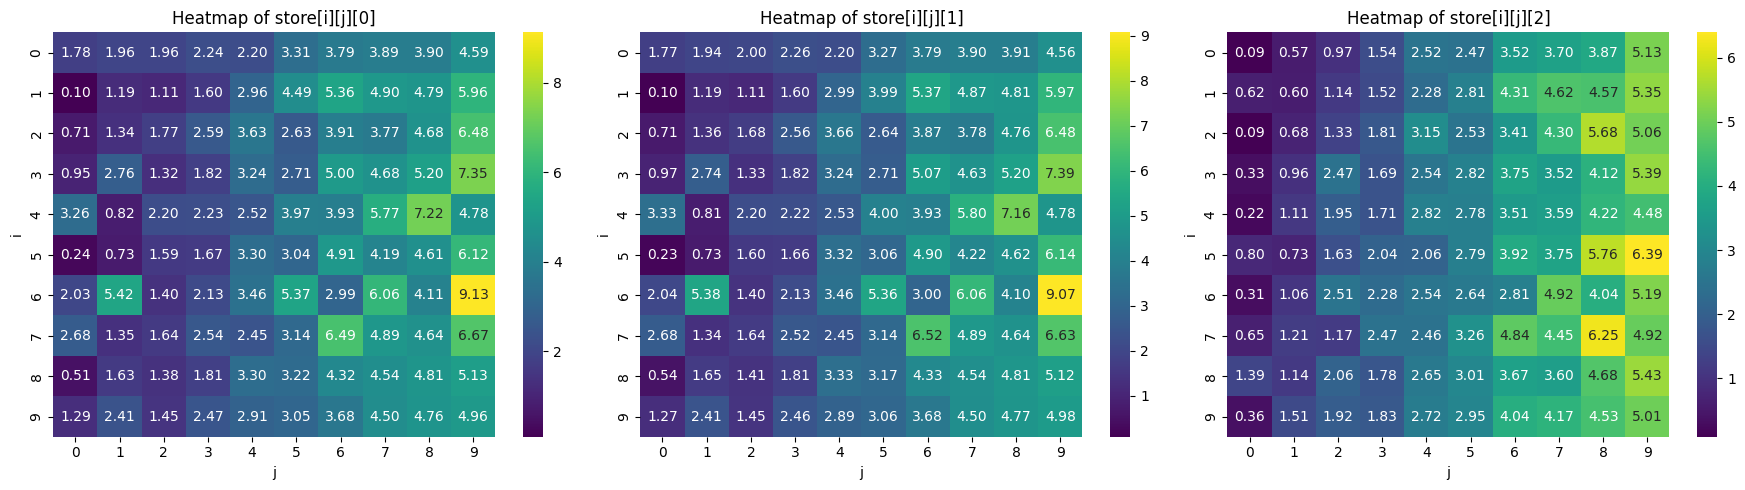

In [58]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Example: Creating 3 NumPy arrays for the 3 "channels" of your data.
heatmap_data_0 = []
heatmap_data_1 = []
heatmap_data_2 = []

for i in range(10):  # or len(store)
    row_0 = []
    row_1 = []
    row_2 = []
    for j in range(10):  # or len(store[i])
        row_0.append(store[i][j][0].item())
        row_1.append(store[i][j][1].item())
        row_2.append(store[i][j][2].item())
    heatmap_data_0.append(row_0)
    heatmap_data_1.append(row_1)
    heatmap_data_2.append(row_2)

# Convert to NumPy arrays (optional but convenient)
heatmap_data_0 = np.array(heatmap_data_0)
heatmap_data_1 = np.array(heatmap_data_1)
heatmap_data_2 = np.array(heatmap_data_2)

# Create subplots: 1 row, 3 columns
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Heatmap for store[i][j][0]
sns.heatmap(
    heatmap_data_0, 
    cmap='viridis', 
    annot=True, 
    fmt=".2f", 
    ax=axes[0]
)
axes[0].set_title("Heatmap of store[i][j][0]")
axes[0].set_xlabel("j")
axes[0].set_ylabel("i")

# Heatmap for store[i][j][1]
sns.heatmap(
    heatmap_data_1,
    cmap='viridis',
    annot=True,
    fmt=".2f",
    ax=axes[1]
)
axes[1].set_title("Heatmap of store[i][j][1]")
axes[1].set_xlabel("j")
axes[1].set_ylabel("i")

# Heatmap for store[i][j][2]
sns.heatmap(
    heatmap_data_2,
    cmap='viridis',
    annot=True,
    fmt=".2f",
    ax=axes[2]
)
axes[2].set_title("Heatmap of store[i][j][2]")
axes[2].set_xlabel("j")
axes[2].set_ylabel("i")

plt.tight_layout()
plt.show()


In [56]:
store[0][0]

(tensor(1.7818, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(1.7700, device='cuda:0', grad_fn=<AddBackward0>),
 tensor(0.0935, device='cuda:0', grad_fn=<AddBackward0>))

In [50]:
import  pickle
with open("store.pkl", "wb") as f:
    pickle.dump(store, f)

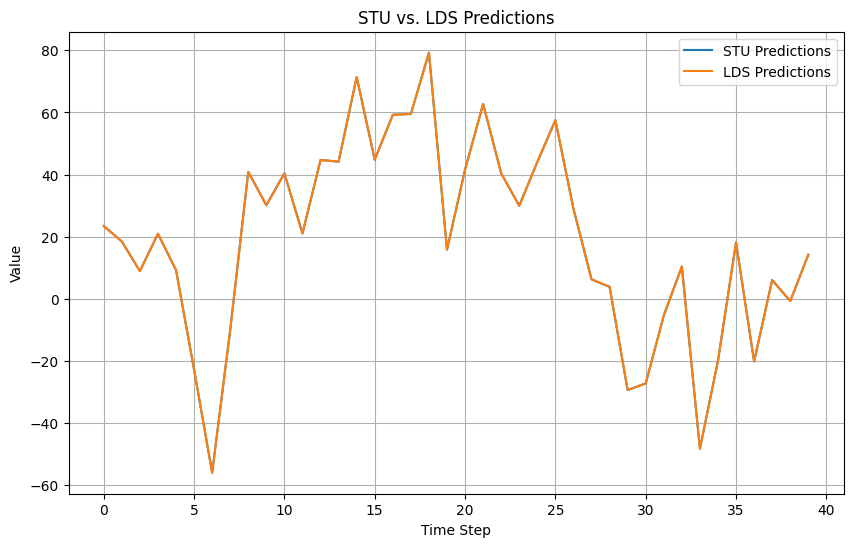

In [ ]:
# prompt: for a given inputs, plot the STUs prediction  compared  to the LDS's prediction

import matplotlib.pyplot as plt
inputs = inputs.reshape(bsz, sl, d_in).to(device)
with torch.no_grad():
    stu_predictions = model(inputs)

inputs = inputs.reshape(bsz * sl, d_in)
lds_predictions = lds.reset().generate_trajectory(inputs.to('cpu')).reshape(-1)


# Plotting
plt.figure(figsize=(10, 6))
plt.plot(stu_predictions[0, :, 0].cpu().numpy(), label='STU Predictions')
plt.plot(lds_predictions.cpu().numpy(), label='LDS Predictions')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.title('STU vs. LDS Predictions')
plt.legend()
plt.grid(True)
plt.show()

In [12]:
stu_predictions

tensor([[[-38.5865],
         [-14.1227],
         [ -9.9030],
         [-23.5759],
         [-38.1899],
         [-30.0572],
         [-16.6309],
         [ 28.5941],
         [ 41.9026],
         [ 28.2184],
         [-52.4404],
         [-24.4163],
         [-34.7976],
         [ -6.1393],
         [-39.4842],
         [  4.5130],
         [-65.1174],
         [-16.6599],
         [-32.1756],
         [-10.6378],
         [ -8.2215],
         [-18.2115],
         [ -9.3991],
         [-19.4214],
         [-30.9072],
         [-33.9235],
         [ 17.3172],
         [-30.2010],
         [ -8.8580],
         [-30.5792],
         [ 27.2570],
         [ -4.1051],
         [-36.3178],
         [ 28.0024],
         [ 10.6769],
         [  2.7303],
         [-17.5152],
         [ 24.7017],
         [  4.4465],
         [-11.2934],
         [  7.6099],
         [-16.0051],
         [  1.5729],
         [ 17.9365],
         [-16.2910],
         [ 22.0622],
         [ 35.2939],
         [  1

In [13]:
lds_predictions

tensor([-38.5865, -14.1227,  -9.9030, -23.5759, -38.1894, -30.0568, -16.6338,
         28.5953,  41.9080,  28.2131, -52.4419, -24.4149, -34.8004,  -6.1349,
        -39.4869,   4.5099, -65.1238, -16.6543, -32.1621, -10.6376,  -8.2164,
        -18.2131,  -9.4032, -19.4257, -30.9054, -33.9297,  17.3129, -30.2021,
         -8.8674, -30.5727,  27.2478,  -4.1026, -36.3113,  27.9922,  10.6793,
          2.7215, -17.5061,  24.6888,   4.4453, -11.2987,   7.6197, -16.0247,
          1.5778,  17.9382, -16.3015,  22.0726,  35.2728,   1.4654,  65.2297,
         24.4254,  43.6025, -22.1452,  14.5858, -55.2574,  -9.1340, -24.3281,
          7.6794,  30.8875,   8.6285,  12.0276,  29.4646,  33.5540,  62.7408,
          2.9914])